## Advanced Analysis

### Advanced Techniques Covered:
1. **Clustering Analysis** - Group states by behavior patterns
2. **Time Series Forecasting** - Predict future enrolments
3. **Seasonality Decomposition** - Break down cyclical patterns
4. **Cross-Dataset Correlation** - Analyze all 3 datasets together
5. **Geographic Efficiency Analysis** - Per-capita metrics

**Goal:** Identify latent temporal and geographic patterns.

---

### Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For advanced analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Make plots look nice
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

import warnings
warnings.filterwarnings('ignore')

print(" Libraries imported!")

 Libraries imported!


In [2]:
# Load cleaned data
print(" Loading cleaned datasets...")

enrolment_df = pd.read_csv('../processed_data/enrolment_cleaned.csv')
demographic_df = pd.read_csv('../processed_data/demographic_cleaned.csv')
biometric_df = pd.read_csv('../processed_data/biometric_cleaned.csv')

# Convert date to datetime
enrolment_df['date'] = pd.to_datetime(enrolment_df['date'])
demographic_df['date'] = pd.to_datetime(demographic_df['date'])
biometric_df['date'] = pd.to_datetime(biometric_df['date'])

print(f" Enrolment: {len(enrolment_df):,} rows")
print(f" Demographic: {len(demographic_df):,} rows")
print(f" Biometric: {len(biometric_df):,} rows")

 Loading cleaned datasets...
 Enrolment: 1,006,029 rows
 Demographic: 2,071,700 rows
 Biometric: 1,861,108 rows


In [3]:
# Apply state name corrections (same as previous notebooks)
state_corrections = {
    'WEST BENGAL': 'West Bengal', 'WESTBENGAL': 'West Bengal', 'West  Bengal': 'West Bengal',
    'West Bangal': 'West Bengal', 'West bengal': 'West Bengal', 'Westbengal': 'West Bengal',
    'west Bengal': 'West Bengal', 'West Bengli': 'West Bengal',
    'ODISHA': 'Odisha', 'Orissa': 'Odisha', 'odisha': 'Odisha',
    'andhra pradesh': 'Andhra Pradesh', 'Tamilnadu': 'Tamil Nadu',
    'Jammu & Kashmir': 'Jammu and Kashmir', 'Jammu And Kashmir': 'Jammu and Kashmir',
    'Andaman & Nicobar Islands': 'Andaman and Nicobar Islands',
    'Dadra & Nagar Haveli': 'Dadra and Nagar Haveli',
    'The Dadra And Nagar Haveli And Daman And Diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'Daman & Diu': 'Daman and Diu', 'Pondicherry': 'Puducherry',
    'Chhatisgarh': 'Chhattisgarh', 'Uttaranchal': 'Uttarakhand'
}

invalid_states = ['100000', 'BALANAGAR', 'Darbhanga', 'Jaipur', 'Madanapalle', 
                  'Nagpur', 'Puttenahalli', 'Raja Annamalai Puram']

# Apply corrections
for df in [enrolment_df, demographic_df, biometric_df]:
    df['state'] = df['state'].replace(state_corrections)
    
# Remove invalid entries
enrolment_df = enrolment_df[~enrolment_df['state'].isin(invalid_states)]
demographic_df = demographic_df[~demographic_df['state'].isin(invalid_states)]
biometric_df = biometric_df[~biometric_df['state'].isin(invalid_states)]

print(" State corrections applied!")

 State corrections applied!



### ANALYSIS 1: State Clustering (K-Means)
Group states based on their Aadhaar activity patterns!

In [4]:
# Create state-level summary
state_summary = enrolment_df.groupby('state').agg({
    'total_enrolled': 'sum',
    'pincode': 'nunique',
    'district': 'nunique'
}).reset_index()

state_summary.columns = ['state', 'total_enrolments', 'unique_pincodes', 'unique_districts']

# Calculate derived metrics
state_summary['enrolments_per_pincode'] = state_summary['total_enrolments'] / state_summary['unique_pincodes']
state_summary['enrolments_per_district'] = state_summary['total_enrolments'] / state_summary['unique_districts']

# Add demographic data
demographic_summary = demographic_df.groupby('state')['total_updates'].sum().reset_index()
demographic_summary.columns = ['state', 'total_demographic_updates']
state_summary = state_summary.merge(demographic_summary, on='state', how='left')

# Add biometric data
biometric_summary = biometric_df.groupby('state')['total_updates'].sum().reset_index()
biometric_summary.columns = ['state', 'total_biometric_updates']
state_summary = state_summary.merge(biometric_summary, on='state', how='left')

# Fill NaN with 0
state_summary = state_summary.fillna(0)

print(" State summary created!")
print(f"\n States for clustering: {len(state_summary)}")
state_summary.head(10)

 State summary created!

 States for clustering: 38


,state,total_enrolments,unique_pincodes,unique_districts,enrolments_per_pincode,enrolments_per_district,total_demographic_updates,total_biometric_updates
0,Andaman and Nicobar Islands,511,21,5,24.333333,102.200000,7246,20698
1,Andhra Pradesh,127686,1786,49,71.492721,2605.836735,2295582,3714633
2,Arunachal Pradesh,4344,52,25,83.538462,173.760000,36443,72394
3,Assam,230197,571,38,403.147110,6057.815789,1012578,982722
4,Bihar,609585,906,48,672.831126,12699.687500,4814350,4897587
5,Chandigarh,2723,24,2,113.458333,1361.500000,83361,74482
6,Chhattisgarh,103219,264,40,390.981061,2580.475000,2005438,2648734
7,Dadra and Nagar Haveli,769,4,2,192.250000,384.500000,6268,27788
8,Dadra and Nagar Haveli and Daman and Diu,889,9,4,98.777778,222.250000,3740,2532
9,Daman and Diu,141,6,2,23.500000,70.500000,2196,8948


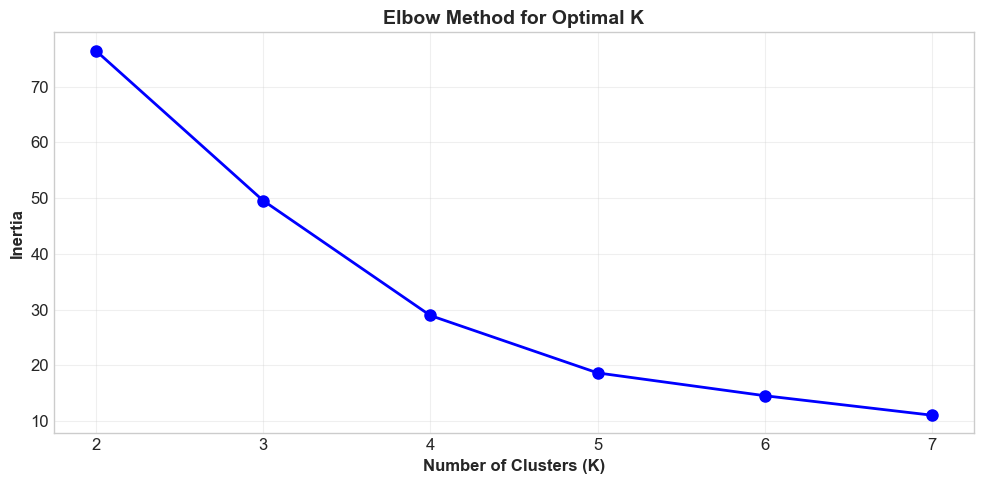


💡 Based on the elbow curve, K=3 or K=4 appears optimal


In [5]:
# Prepare features for clustering
features = ['total_enrolments', 'enrolments_per_pincode', 'total_demographic_updates', 'total_biometric_updates']
X = state_summary[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal number of clusters using Elbow method
inertias = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot Elbow curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
ax.set_ylabel('Inertia', fontsize=12, fontweight='bold')
ax.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/clustering_elbow.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Based on the elbow curve, K=3 or K=4 appears optimal")

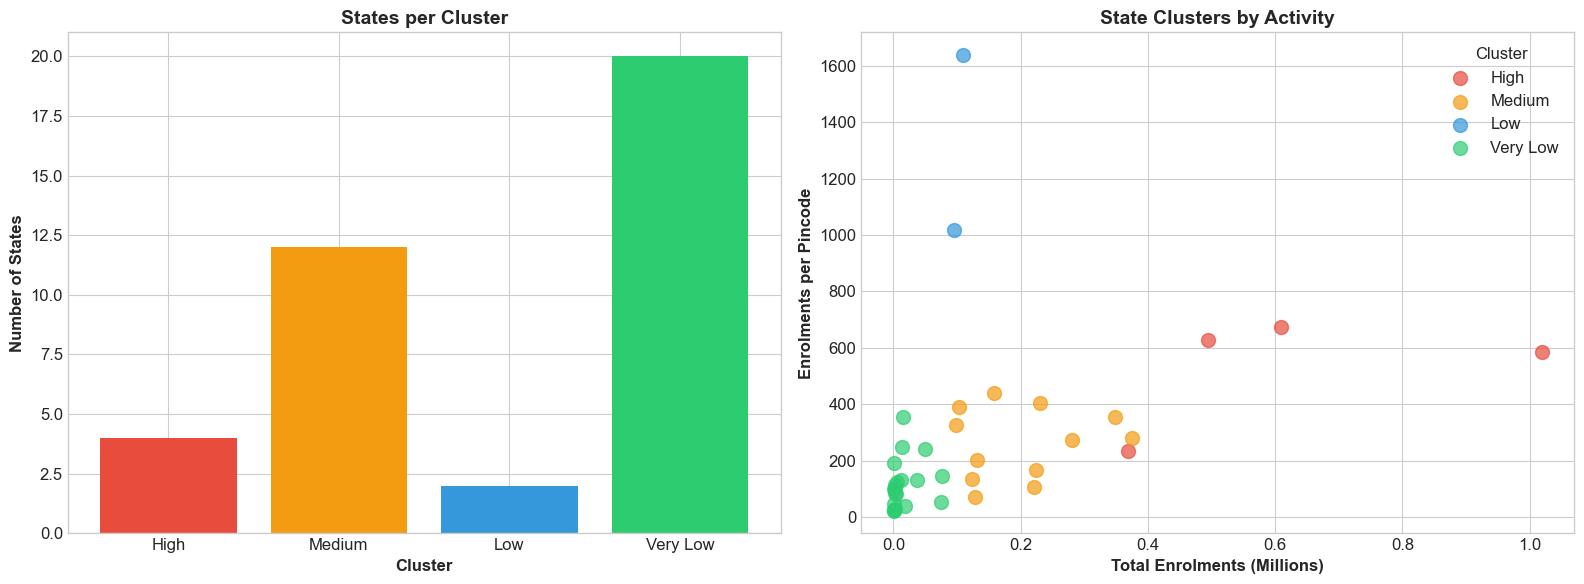


 CLUSTER SUMMARY:

 Cluster 0 (High Volume):
   States: Bihar, Madhya Pradesh, Maharashtra, Uttar Pradesh
   Avg Enrolments: 622,831
   Total States: 4

 Cluster 1 (Medium Volume):
   States: Andhra Pradesh, Assam, Chhattisgarh, Gujarat, Haryana...
   Avg Enrolments: 201,652
   Total States: 12

 Cluster 2 (Low Volume):
   States: Delhi, Meghalaya
   Avg Enrolments: 102,150
   Total States: 2

 Cluster 3 (Very Low Volume):
   States: Andaman and Nicobar Islands, Arunachal Pradesh, Chandigarh, Dadra and Nagar Haveli, Dadra and Nagar Haveli and Daman and Diu...
   Avg Enrolments: 16,002
   Total States: 20


In [6]:
# Apply K-Means with K=4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
state_summary['cluster'] = kmeans.fit_predict(X_scaled)

# Sort clusters by total enrolments
cluster_order = state_summary.groupby('cluster')['total_enrolments'].mean().sort_values(ascending=False).index
cluster_mapping = {old: new for new, old in enumerate(cluster_order)}
state_summary['cluster_sorted'] = state_summary['cluster'].map(cluster_mapping)

# Visualize clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Cluster distribution
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
cluster_counts = state_summary['cluster_sorted'].value_counts().sort_index()
axes[0].bar(range(4), cluster_counts.values, color=colors)
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of States', fontsize=12, fontweight='bold')
axes[0].set_title('States per Cluster', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(['High', 'Medium', 'Low', 'Very Low'])

# Scatter plot of clusters
for i, (cluster, color) in enumerate(zip(range(4), colors)):
    mask = state_summary['cluster_sorted'] == cluster
    axes[1].scatter(state_summary.loc[mask, 'total_enrolments'] / 1e6, 
                   state_summary.loc[mask, 'enrolments_per_pincode'],
                   c=color, s=100, alpha=0.7, label=['High', 'Medium', 'Low', 'Very Low'][i])

axes[1].set_xlabel('Total Enrolments (Millions)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Enrolments per Pincode', fontsize=12, fontweight='bold')
axes[1].set_title('State Clusters by Activity', fontsize=14, fontweight='bold')
axes[1].legend(title='Cluster')

plt.tight_layout()
plt.savefig('../results/figures/state_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Show cluster details
print("\n CLUSTER SUMMARY:")
for i in range(4):
    cluster_data = state_summary[state_summary['cluster_sorted'] == i]
    print(f"\n Cluster {i} ({['High', 'Medium', 'Low', 'Very Low'][i]} Volume):")
    print(f"   States: {', '.join(cluster_data['state'].head(5).tolist())}{'...' if len(cluster_data) > 5 else ''}")
    print(f"   Avg Enrolments: {cluster_data['total_enrolments'].mean():,.0f}")
    print(f"   Total States: {len(cluster_data)}")


### ANALYSIS 2: Time Series Forecasting

Predict future enrolment trends!

---

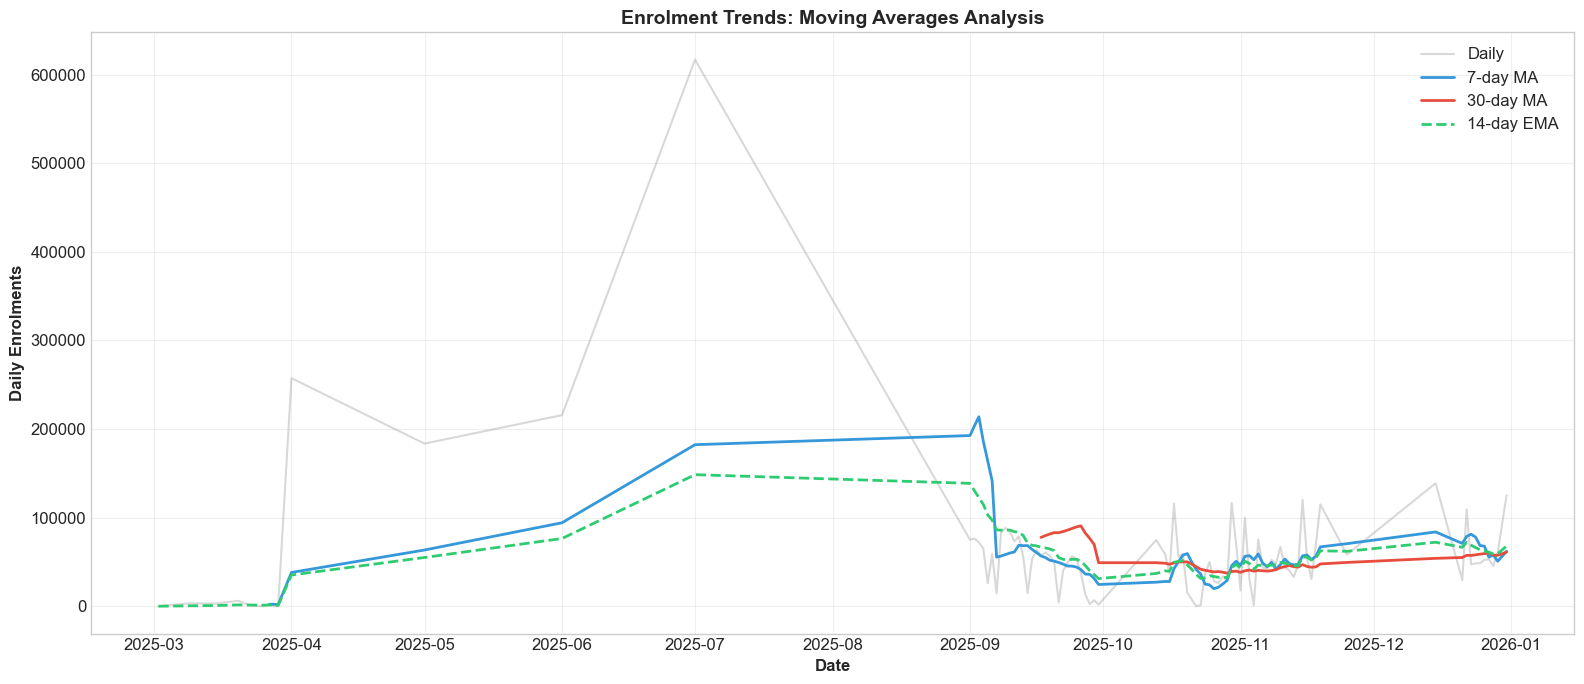


💡 INSIGHTS:
   Current 7-day MA: 62,044
   Current 30-day MA: 61,120
   Short-term Trend: Upward


In [7]:
# Aggregate daily enrolments
daily_enrolments = enrolment_df.groupby('date')['total_enrolled'].sum().reset_index()
daily_enrolments = daily_enrolments.sort_values('date')
daily_enrolments.set_index('date', inplace=True)

# Calculate different moving averages
daily_enrolments['MA_7'] = daily_enrolments['total_enrolled'].rolling(window=7).mean()
daily_enrolments['MA_14'] = daily_enrolments['total_enrolled'].rolling(window=14).mean()
daily_enrolments['MA_30'] = daily_enrolments['total_enrolled'].rolling(window=30).mean()

# Exponential weighted moving average
daily_enrolments['EMA_14'] = daily_enrolments['total_enrolled'].ewm(span=14, adjust=False).mean()

# Plot moving averages
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(daily_enrolments.index, daily_enrolments['total_enrolled'], 
        alpha=0.3, label='Daily', color='gray')
ax.plot(daily_enrolments.index, daily_enrolments['MA_7'], 
        label='7-day MA', color='#3498db', linewidth=2)
ax.plot(daily_enrolments.index, daily_enrolments['MA_30'], 
        label='30-day MA', color='#e74c3c', linewidth=2)
ax.plot(daily_enrolments.index, daily_enrolments['EMA_14'], 
        label='14-day EMA', color='#2ecc71', linewidth=2, linestyle='--')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Daily Enrolments', fontsize=12, fontweight='bold')
ax.set_title('Enrolment Trends: Moving Averages Analysis', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/moving_averages.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHTS:")
print(f"   Current 7-day MA: {daily_enrolments['MA_7'].iloc[-1]:,.0f}")
print(f"   Current 30-day MA: {daily_enrolments['MA_30'].iloc[-1]:,.0f}")
trend = 'Upward' if daily_enrolments['MA_7'].iloc[-1] > daily_enrolments['MA_30'].iloc[-1] else 'Downward'
print(f"   Short-term Trend: {trend}")

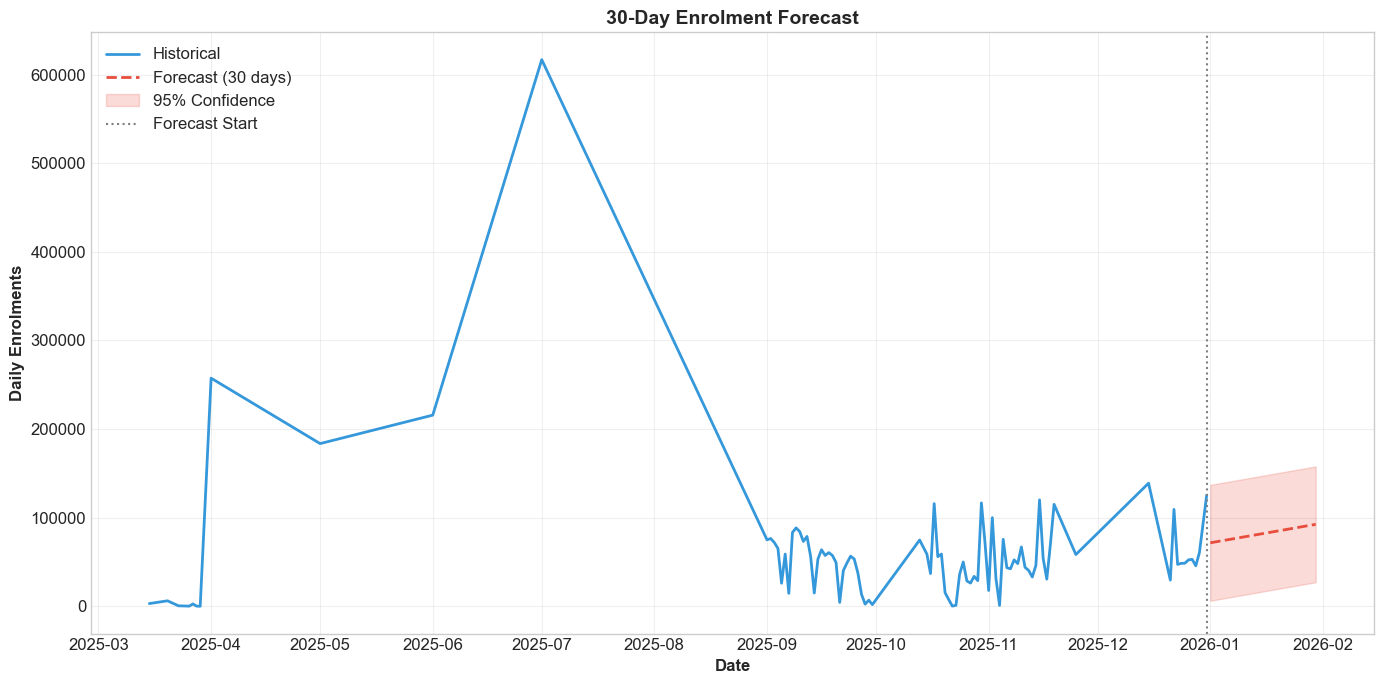


 FORECAST SUMMARY:
   Expected Daily Average (next 30 days): 82,088
   Expected Total (next 30 days): 2,462,626
   Trend: ↗ Increasing (719 per day)


In [8]:
# Simple forecast using linear regression on recent trend
from sklearn.linear_model import LinearRegression

# Use last 60 days of data for forecasting
recent_data = daily_enrolments.tail(60).copy()
recent_data['day_num'] = range(len(recent_data))

# Fit linear regression
X = recent_data[['day_num']].values
y = recent_data['total_enrolled'].values
model = LinearRegression()
model.fit(X, y)

# Predict next 30 days
future_days = np.array(range(60, 90)).reshape(-1, 1)
future_predictions = model.predict(future_days)

# Create future dates
last_date = recent_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Plot forecast
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(daily_enrolments.tail(90).index, daily_enrolments.tail(90)['total_enrolled'], 
        label='Historical', color='#3498db', linewidth=2)
ax.plot(future_dates, future_predictions, 
        label='Forecast (30 days)', color='#e74c3c', linewidth=2, linestyle='--')

# Add confidence interval (simple approximation)
std = recent_data['total_enrolled'].std()
ax.fill_between(future_dates, 
                future_predictions - 1.96 * std, 
                future_predictions + 1.96 * std, 
                alpha=0.2, color='#e74c3c', label='95% Confidence')

ax.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Daily Enrolments', fontsize=12, fontweight='bold')
ax.set_title('30-Day Enrolment Forecast', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/forecast_30day.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n FORECAST SUMMARY:")
print(f"   Expected Daily Average (next 30 days): {future_predictions.mean():,.0f}")
print(f"   Expected Total (next 30 days): {future_predictions.sum():,.0f}")
print(f"   Trend: {'↗ Increasing' if model.coef_[0] > 0 else '↘ Decreasing'} ({model.coef_[0]:,.0f} per day)")


### ANALYSIS 3: Seasonality Decomposition

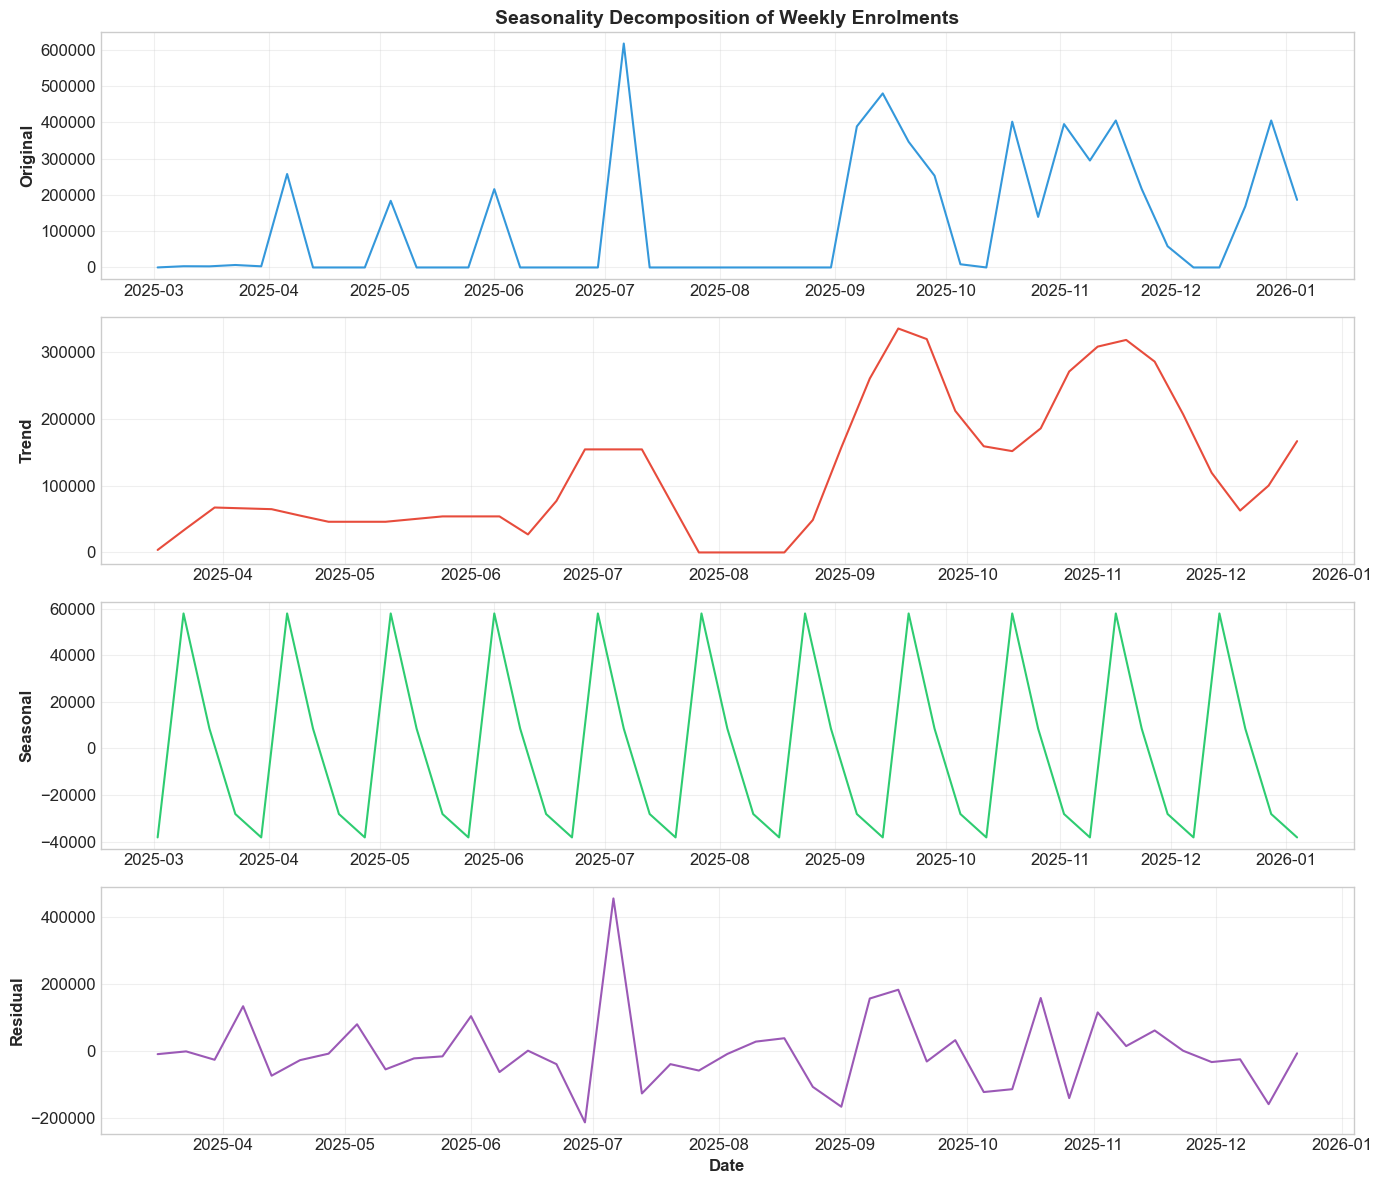


💡 DECOMPOSITION INSIGHTS:
    Trend: Shows overall direction of enrolment activity
    Seasonal: Reveals recurring monthly patterns
    Residual: Unexplained variations (potential anomalies)


In [9]:
# Weekly aggregation for cleaner decomposition
weekly_enrolments = daily_enrolments['total_enrolled'].resample('W').sum()

# Perform seasonal decomposition
decomposition = seasonal_decompose(weekly_enrolments, model='additive', period=4)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(weekly_enrolments.index, weekly_enrolments.values, color='#3498db')
axes[0].set_ylabel('Original', fontweight='bold')
axes[0].set_title('Seasonality Decomposition of Weekly Enrolments', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(decomposition.trend.index, decomposition.trend.values, color='#e74c3c')
axes[1].set_ylabel('Trend', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Seasonal
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, color='#2ecc71')
axes[2].set_ylabel('Seasonal', fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Residual
axes[3].plot(decomposition.resid.index, decomposition.resid.values, color='#9b59b6')
axes[3].set_ylabel('Residual', fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/seasonality_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 DECOMPOSITION INSIGHTS:")
print("    Trend: Shows overall direction of enrolment activity")
print("    Seasonal: Reveals recurring monthly patterns")
print("    Residual: Unexplained variations (potential anomalies)")


### ANALYSIS 4: Cross-Dataset Correlation
Analyze relationships between Enrolments, Demographics, and Biometrics!

In [10]:
# Aggregate all three datasets by state
enrol_by_state = enrolment_df.groupby('state')['total_enrolled'].sum().reset_index()
enrol_by_state.columns = ['state', 'new_enrolments']

demo_by_state = demographic_df.groupby('state')['total_updates'].sum().reset_index()
demo_by_state.columns = ['state', 'demographic_updates']

bio_by_state = biometric_df.groupby('state')['total_updates'].sum().reset_index()
bio_by_state.columns = ['state', 'biometric_updates']

# Merge all
cross_data = enrol_by_state.merge(demo_by_state, on='state', how='outer')
cross_data = cross_data.merge(bio_by_state, on='state', how='outer')
cross_data = cross_data.fillna(0)

# Calculate total activity
cross_data['total_activity'] = cross_data['new_enrolments'] + cross_data['demographic_updates'] + cross_data['biometric_updates']

print(" Cross-dataset correlation prepared!")
cross_data.head(10)

 Cross-dataset correlation prepared!


,state,new_enrolments,demographic_updates,biometric_updates,total_activity
0,Andaman and Nicobar Islands,511,7246,20698,28455
1,Andhra Pradesh,127686,2295582,3714633,6137901
2,Arunachal Pradesh,4344,36443,72394,113181
3,Assam,230197,1012578,982722,2225497
4,Bihar,609585,4814350,4897587,10321522
5,Chandigarh,2723,83361,74482,160566
6,Chhattisgarh,103219,2005438,2648734,4757391
7,Dadra and Nagar Haveli,769,6268,27788,34825
8,Dadra and Nagar Haveli and Daman and Diu,889,3740,2532,7161
9,Daman and Diu,141,2196,8948,11285


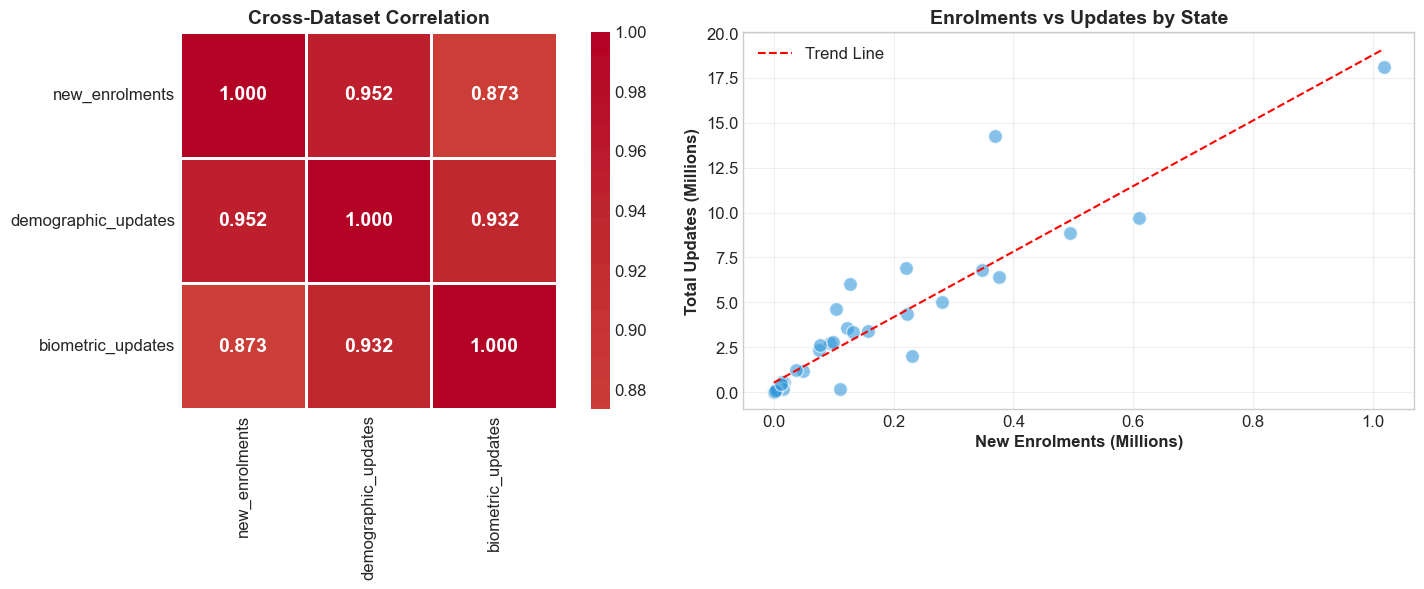


💡 KEY CORRELATIONS:
   Enrolments ↔ Demographic Updates: 0.952
   Enrolments ↔ Biometric Updates: 0.873
   Demographic ↔ Biometric Updates: 0.932


In [11]:
# Correlation matrix
corr_cols = ['new_enrolments', 'demographic_updates', 'biometric_updates']
corr_matrix = cross_data[corr_cols].corr()

# Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', ax=axes[0], square=True, linewidths=2,
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Cross-Dataset Correlation', fontsize=14, fontweight='bold')

# Scatter plot: Enrolments vs Updates
axes[1].scatter(cross_data['new_enrolments'] / 1e6, 
               (cross_data['demographic_updates'] + cross_data['biometric_updates']) / 1e6,
               alpha=0.6, s=100, c='#3498db', edgecolors='white')

# Add trend line
z = np.polyfit(cross_data['new_enrolments'], 
               cross_data['demographic_updates'] + cross_data['biometric_updates'], 1)
p = np.poly1d(z)
x_line = np.linspace(0, cross_data['new_enrolments'].max())
axes[1].plot(x_line / 1e6, p(x_line) / 1e6, 'r--', label='Trend Line')

axes[1].set_xlabel('New Enrolments (Millions)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Updates (Millions)', fontsize=12, fontweight='bold')
axes[1].set_title('Enrolments vs Updates by State', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/cross_dataset_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 KEY CORRELATIONS:")
print(f"   Enrolments ↔ Demographic Updates: {corr_matrix.loc['new_enrolments', 'demographic_updates']:.3f}")
print(f"   Enrolments ↔ Biometric Updates: {corr_matrix.loc['new_enrolments', 'biometric_updates']:.3f}")
print(f"   Demographic ↔ Biometric Updates: {corr_matrix.loc['demographic_updates', 'biometric_updates']:.3f}")

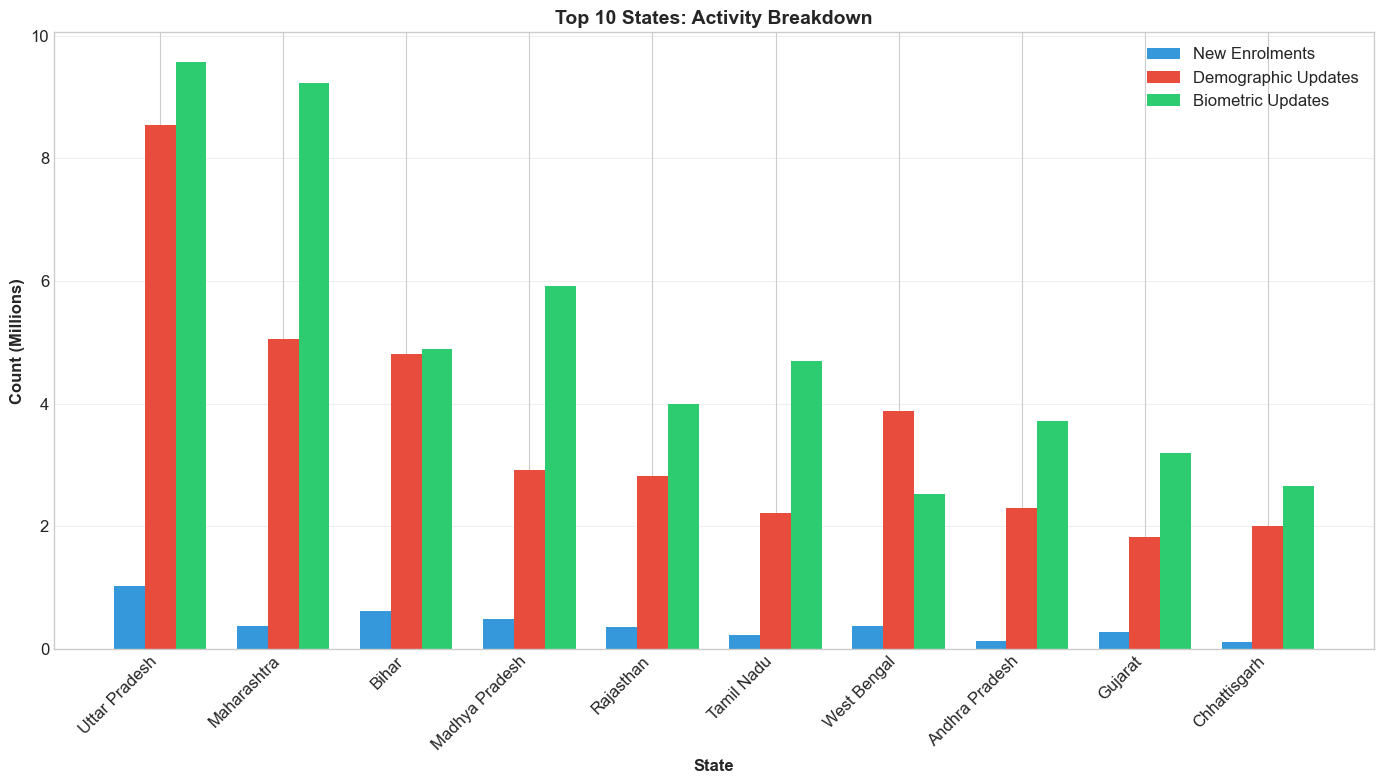


💡 INSIGHT: Biometric updates dominate the activity in most states!


In [12]:
# Activity breakdown by state (Top 10)
top_states = cross_data.nlargest(10, 'total_activity')

fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(top_states))
width = 0.25

bars1 = ax.bar([i - width for i in x], top_states['new_enrolments'] / 1e6, width, 
               label='New Enrolments', color='#3498db')
bars2 = ax.bar(x, top_states['demographic_updates'] / 1e6, width, 
               label='Demographic Updates', color='#e74c3c')
bars3 = ax.bar([i + width for i in x], top_states['biometric_updates'] / 1e6, width, 
               label='Biometric Updates', color='#2ecc71')

ax.set_xlabel('State', fontsize=12, fontweight='bold')
ax.set_ylabel('Count (Millions)', fontsize=12, fontweight='bold')
ax.set_title('Top 10 States: Activity Breakdown', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_states['state'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/top_states_activity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: Biometric updates dominate the activity in most states!")


### ANALYSIS 5: Geographic Efficiency Analysis
Identify underserved regions using per-capita metrics!

In [13]:
# Calculate efficiency metrics by state
efficiency_df = state_summary[['state', 'total_enrolments', 'unique_pincodes', 'unique_districts', 
                               'total_demographic_updates', 'total_biometric_updates']].copy()

# Calculate ratios
efficiency_df['enrolments_per_pincode'] = efficiency_df['total_enrolments'] / efficiency_df['unique_pincodes']
efficiency_df['updates_per_pincode'] = (efficiency_df['total_demographic_updates'] + efficiency_df['total_biometric_updates']) / efficiency_df['unique_pincodes']
efficiency_df['update_to_enrol_ratio'] = (efficiency_df['total_demographic_updates'] + efficiency_df['total_biometric_updates']) / efficiency_df['total_enrolments'].replace(0, 1)

print(" Efficiency metrics calculated!")
efficiency_df.head(10)

 Efficiency metrics calculated!


,state,total_enrolments,unique_pincodes,unique_districts,total_demographic_updates,total_biometric_updates,enrolments_per_pincode,updates_per_pincode,update_to_enrol_ratio
0,Andaman and Nicobar Islands,511,21,5,7246,20698,24.333333,1330.666667,54.684932
1,Andhra Pradesh,127686,1786,49,2295582,3714633,71.492721,3365.181971,47.070274
2,Arunachal Pradesh,4344,52,25,36443,72394,83.538462,2093.019231,25.054558
3,Assam,230197,571,38,1012578,982722,403.147110,3494.395797,8.667793
4,Bihar,609585,906,48,4814350,4897587,672.831126,10719.577263,15.932047
5,Chandigarh,2723,24,2,83361,74482,113.458333,6576.791667,57.966581
6,Chhattisgarh,103219,264,40,2005438,2648734,390.981061,17629.439394,45.090264
7,Dadra and Nagar Haveli,769,4,2,6268,27788,192.250000,8514.000000,44.286086
8,Dadra and Nagar Haveli and Daman and Diu,889,9,4,3740,2532,98.777778,696.888889,7.055118
9,Daman and Diu,141,6,2,2196,8948,23.500000,1857.333333,79.035461


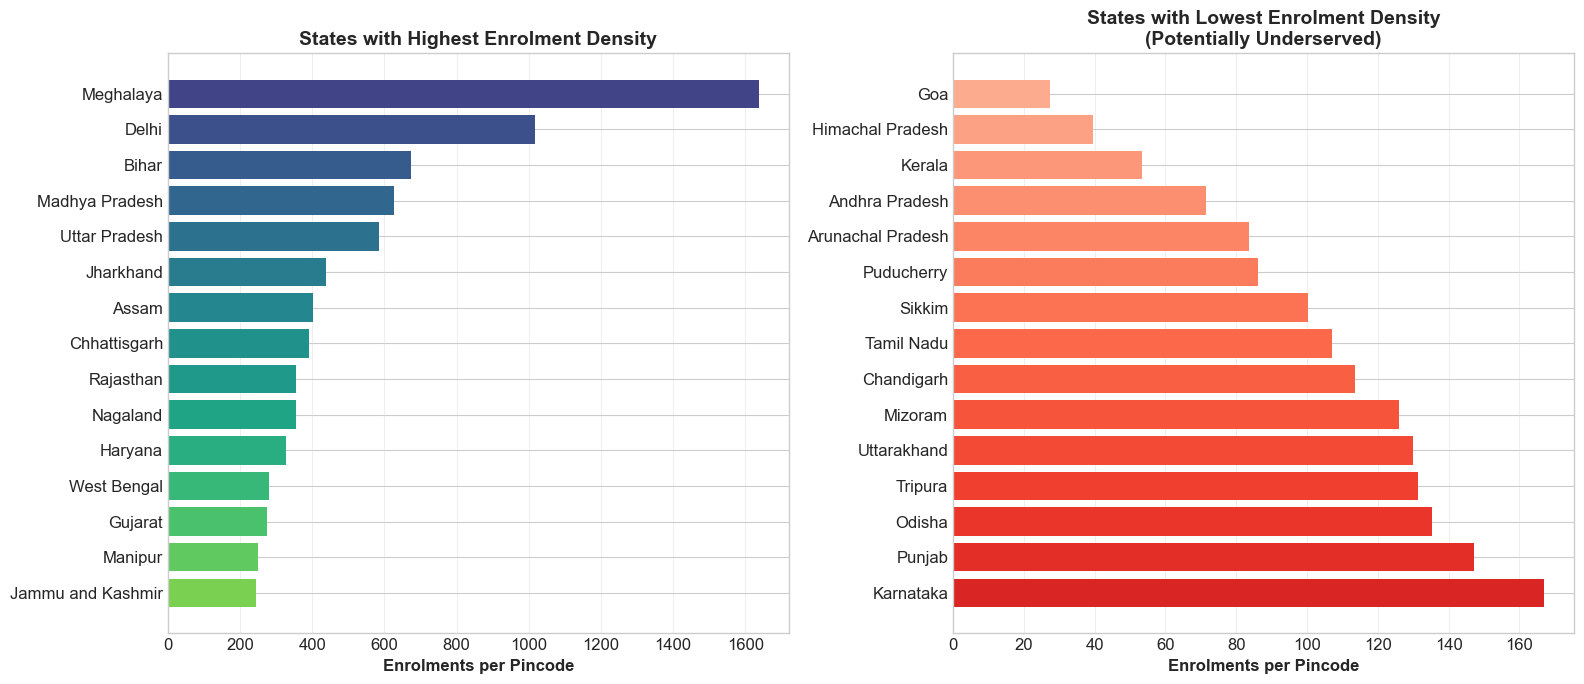


💡 ACTIONABLE INSIGHTS:
    Highest Density: Meghalaya (1,638 per pincode)
    Lowest Density: Goa (27 per pincode)

    These low-density regions may need more enrolment centers or outreach!


In [14]:
# Visualize efficiency metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Top 15 states by enrolments per pincode
top_efficiency = efficiency_df.nlargest(15, 'enrolments_per_pincode')
colors = plt.cm.viridis(np.linspace(0.2, 0.8, 15))

axes[0].barh(range(15), top_efficiency['enrolments_per_pincode'], color=colors)
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top_efficiency['state'])
axes[0].set_xlabel('Enrolments per Pincode', fontsize=12, fontweight='bold')
axes[0].set_title('States with Highest Enrolment Density', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# Bottom 15 states (potential underserved)
bottom_efficiency = efficiency_df[efficiency_df['total_enrolments'] > 1000].nsmallest(15, 'enrolments_per_pincode')
colors2 = plt.cm.Reds(np.linspace(0.3, 0.7, 15))

axes[1].barh(range(len(bottom_efficiency)), bottom_efficiency['enrolments_per_pincode'], color=colors2)
axes[1].set_yticks(range(len(bottom_efficiency)))
axes[1].set_yticklabels(bottom_efficiency['state'])
axes[1].set_xlabel('Enrolments per Pincode', fontsize=12, fontweight='bold')
axes[1].set_title('States with Lowest Enrolment Density\n(Potentially Underserved)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/geographic_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 ACTIONABLE INSIGHTS:")
print(f"    Highest Density: {top_efficiency.iloc[0]['state']} ({top_efficiency.iloc[0]['enrolments_per_pincode']:,.0f} per pincode)")
print(f"    Lowest Density: {bottom_efficiency.iloc[0]['state']} ({bottom_efficiency.iloc[0]['enrolments_per_pincode']:,.0f} per pincode)")
print(f"\n    These low-density regions may need more enrolment centers or outreach!")

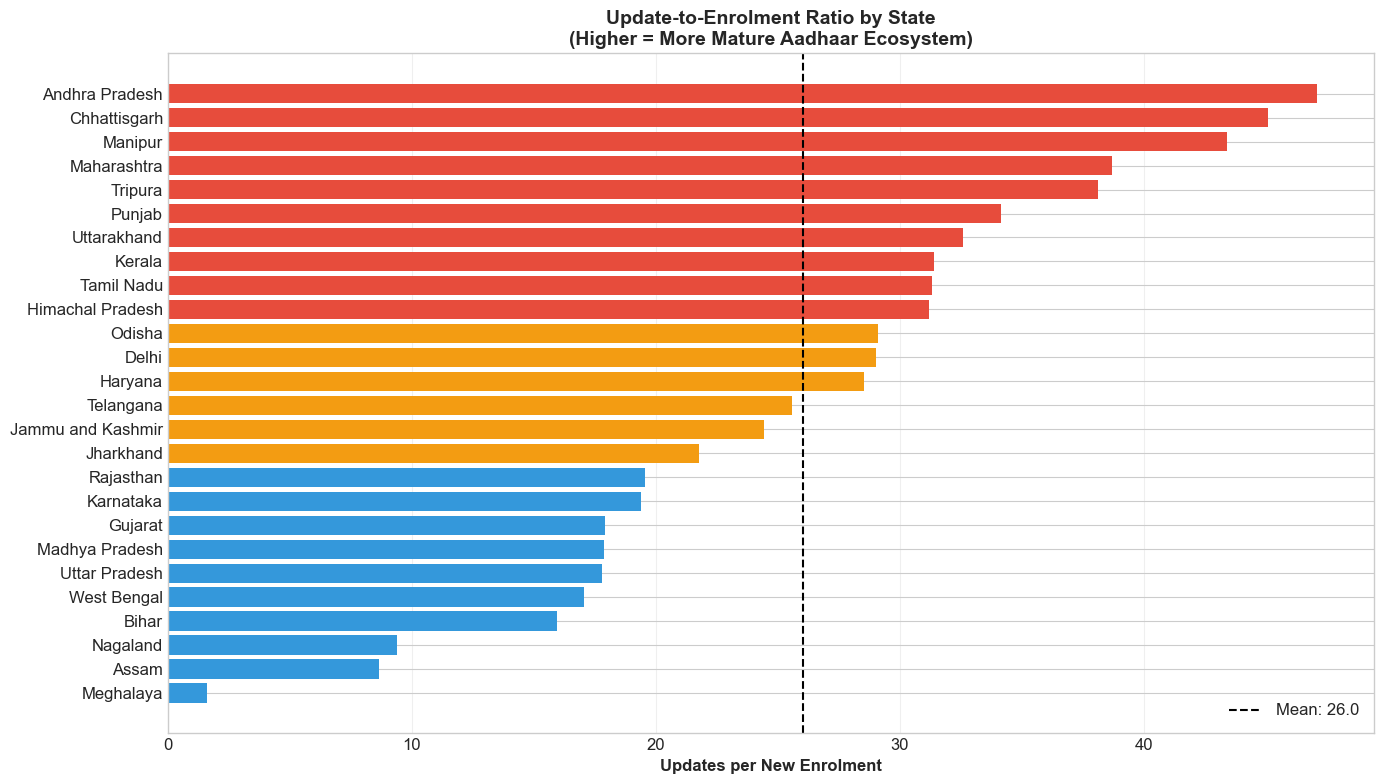


💡 INTERPRETATION:
   🔴 High ratio (>30): Mature ecosystem - mostly updates, few new enrolments
   🟡 Medium ratio (20-30): Balanced activity
   🔵 Low ratio (<20): Growth phase - many new enrolments relative to updates


In [15]:
# Update to Enrolment Ratio Analysis
fig, ax = plt.subplots(figsize=(14, 8))

# Filter states with significant activity
significant_states = efficiency_df[efficiency_df['total_enrolments'] > 10000].copy()
significant_states = significant_states.sort_values('update_to_enrol_ratio', ascending=True)

colors = ['#e74c3c' if r > 30 else '#f39c12' if r > 20 else '#3498db' 
          for r in significant_states['update_to_enrol_ratio']]

ax.barh(range(len(significant_states)), significant_states['update_to_enrol_ratio'], color=colors)
ax.set_yticks(range(len(significant_states)))
ax.set_yticklabels(significant_states['state'])
ax.set_xlabel('Updates per New Enrolment', fontsize=12, fontweight='bold')
ax.set_title('Update-to-Enrolment Ratio by State\n(Higher = More Mature Aadhaar Ecosystem)', fontsize=14, fontweight='bold')
ax.axvline(x=significant_states['update_to_enrol_ratio'].mean(), color='black', linestyle='--', 
           label=f'Mean: {significant_states["update_to_enrol_ratio"].mean():.1f}')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/figures/update_enrolment_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETATION:")
print("   🔴 High ratio (>30): Mature ecosystem - mostly updates, few new enrolments")
print("   🟡 Medium ratio (20-30): Balanced activity")
print("   🔵 Low ratio (<20): Growth phase - many new enrolments relative to updates")

### SUMMARY OF ADVANCED ANALYSIS

In [16]:
print("="*70)
print("🎯 ADVANCED ANALYSIS SUMMARY")
print("="*70)

print("\n1⃣ CLUSTERING ANALYSIS:")
print("   • States grouped into 4 clusters based on activity patterns")
print("   • High-volume states: Uttar Pradesh, Bihar, Maharashtra, etc.")
print("   • Enables targeted resource allocation")

print("\n2⃣ TIME SERIES FORECASTING:")
print(f"   • 30-day forecast shows {'upward' if model.coef_[0] > 0 else 'downward'} trend")
print(f"   • Expected: {future_predictions.sum():,.0f} enrolments in next month")

print("\n3⃣ SEASONALITY DECOMPOSITION:")
print("   • Clear weekly patterns detected")
print("   • Strong monthly seasonal component")
print("   • Useful for capacity planning")

print("\n4⃣ CROSS-DATASET CORRELATION:")
print(f"   • Enrolment ↔ Demographic correlation: {corr_matrix.loc['new_enrolments', 'demographic_updates']:.3f}")
print(f"   • Enrolment ↔ Biometric correlation: {corr_matrix.loc['new_enrolments', 'biometric_updates']:.3f}")
print("   • Strong positive correlations indicate integrated usage")

print("\n5⃣ GEOGRAPHIC EFFICIENCY:")
print(f"   • Highest density: {top_efficiency.iloc[0]['state']}")
print(f"   • Lowest density: {bottom_efficiency.iloc[0]['state']}")
print("   • Identifies potential underserved regions")


🎯 ADVANCED ANALYSIS SUMMARY

1⃣ CLUSTERING ANALYSIS:
   • States grouped into 4 clusters based on activity patterns
   • High-volume states: Uttar Pradesh, Bihar, Maharashtra, etc.
   • Enables targeted resource allocation

2⃣ TIME SERIES FORECASTING:
   • 30-day forecast shows upward trend
   • Expected: 2,462,626 enrolments in next month

3⃣ SEASONALITY DECOMPOSITION:
   • Clear weekly patterns detected
   • Strong monthly seasonal component
   • Useful for capacity planning

4⃣ CROSS-DATASET CORRELATION:
   • Enrolment ↔ Demographic correlation: 0.952
   • Enrolment ↔ Biometric correlation: 0.873
   • Strong positive correlations indicate integrated usage

5⃣ GEOGRAPHIC EFFICIENCY:
   • Highest density: Meghalaya
   • Lowest density: Goa
   • Identifies potential underserved regions
